In [1]:
#| default_exp kalman
%load_ext autoreload
%autoreload 2

# libraries for this notebook
import jax
import numpy.testing as npt
import matplotlib.pyplot as plt

In [ ]:
config = jax.config
# use x86 for testing purposes
config.update("jax_enable_x64", True)

# Kalman filter and smoother variants in JAX




Consider a state space model of the form
$$
\begin{align*}
    X_0 &\sim \mathcal N (x_0, \Sigma_0) &\\
    X_{t + 1} &= A_t X_{t} + \varepsilon_{t + 1} &t = 0, \dots, n - 1\\
    \varepsilon_t &\sim \mathcal N (0, \Sigma_t) & t = 1, \dots, n \\
    Y_t &= B_t X_t + \eta_t & t =0, \dots, n & \\
    \eta_t &\sim \mathcal N(0, \Omega_T), & t=0, \dots, n.
\end{align*}
$$



For $t, s \in \{0, \dots, n\}$ consider the following BLPs and associated covariance matrices
$$
\begin{align*}
    \hat X_{t|s} &= \mathbf E \left( X_t | Y_s, \dots, Y_0\right) \\
    \Xi_{t | s} &= \text{Cov} \left(X_t | Y_s, \dots, Y_0 \right)\\
    \hat Y_{t|s} &= \mathbf E \left( Y_t | Y_s, \dots, Y_0\right) \\
    \Psi_{t | s} &= \text{Cov} \left(Y_t | Y_s, \dots, Y_0 \right)
\end{align*}
$$

The Kalman filter consists of the following two-step recursion:

#### Initialization
$$
\begin{align*}
\hat X_{0|0} &= x_0\\
\Xi_{0|0} &= \Sigma_0
\end{align*}
$$

Iterate for $t = 0, \dots, n-1$

#### Prediction
$$
\begin{align*}
    \hat X_{t + 1|t} &= A_t \hat X_{t | t} \\
    \Xi_{t + 1 | t} &= A_t \Xi_{t|t} A_t^T + \Sigma_t\\
\end{align*}
$$

#### Filtering
$$
\begin{align*}
    \hat Y_{t + 1 | t} &= B_t \hat X_{t + 1 | t} \\
    \Psi_{t + 1| t} &= B_{t + 1} \Xi_{t + 1 | t} B_{t + 1}^T + \Omega_{t + 1}\\
    K_t &= \Xi_{t + 1 | t} B_{t + 1}^T \Psi_{t + 1 | t} ^{-1} \\
    \hat X_{t + 1 | t + 1} &= \hat X_{t + 1 | t} + K_t (Y_{t + 1} - \hat Y_{t + 1 | t})\\
    \Xi_{t + 1 | t + 1} &= \Xi_{t + 1 | t} - K_t \Psi_{t + 1| t} K_t^T 
\end{align*}
$$


In [ ]:
#| export
import jax.numpy as jnp
from jaxtyping import Float, Array
import jax.scipy.linalg as jsla
from jax.lax import scan
from jax import vmap

import tensorflow_probability.substrates.jax.distributions as tfd

def predict(
    x_filt: Float[Array, "m"], # $X_{t|t}$
    Xi_filt: Float[Array, "m m"], # $\Xi_{t|t}
    A: Float[Array, "m m"], # $A_t$
    Sigma: Float[Array, "m m"], # $\Sigma_{t + 1}
):
    x_pred = A @ x_filt
    Xi_pred = A @ Xi_filt @ A.T + Sigma

    return x_pred, Xi_pred


def filter(
    x_pred: Float[Array, "m"],
    Xi_pred: Float[Array, "m m"],
    y: Float[Array, "p"],
    B: Float[Array, "p m"],
    Omega: Float[Array, "p p"],
):
    y_pred = B @ x_pred
    Psi_pred = B @ Xi_pred @ B.T + Omega
    K = Xi_pred @ jsla.solve(Psi_pred, B).T
    x_filt = x_pred + K @ (y - y_pred)
    Xi_filt = Xi_pred - K @ Psi_pred @ K.T

    return x_filt, Xi_filt


def kalman(
    y: Float[Array, "n+1 p"],
    x0: Float[Array, "m"],
    Sigma: Float[Array, "n+1 m m"],
    Omega: Float[Array, "n+1 p p"],
    A: Float[Array, "n m m"],
    B: Float[Array, "n+1 p m"],
):
    def step(carry, inputs):
        x_filt, Xi_filt = carry
        y, Sigma, Omega, A, B = inputs

        x_pred, Xi_pred = predict(x_filt, Xi_filt, A, Sigma)
        x_filt_next, Xi_filt_next = filter(x_pred, Xi_pred, y, B, Omega)

        return (x_filt_next, Xi_filt_next), (x_filt_next, Xi_filt_next, x_pred, Xi_pred)

    # artificial state X_{-1} with mean x_0
    # covariance zero, transition identity
    # will lead to X_0 having correct predictive distribution
    # this avoids having to compute a separate filtering step beforehand
    m, = x0.shape
    A_ext = jnp.concatenate(
        (jnp.eye(m)[jnp.newaxis], A)
    )

    _, (x_filt, Xi_filt, x_pred, Xi_pred) = scan(
        step, (x0, jnp.zeros_like(Sigma[0])), (y, Sigma, Omega, A_ext, B)
    )

    return x_filt, Xi_filt, x_pred, Xi_pred

/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.2 when it was built against 1.14.1, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [ ]:
from isssm.glssm_models import common_factor_lcm
from isssm.glssm import simulate_glssm
import jax.random as jrn

In [ ]:
x0, A, B, Sigma, Omega = common_factor_lcm(
    100, jnp.zeros(3), jnp.eye(3), 2., 3.
)

(x,), (y,) = simulate_glssm(x0, A, B, Sigma, Omega, 1, jrn.PRNGKey(53405234))

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


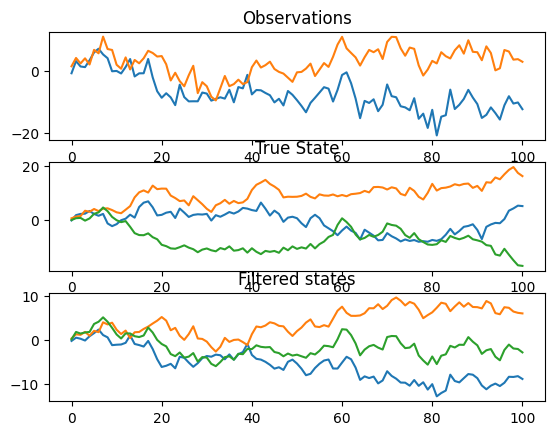

In [ ]:
x_filt, Xi_filt, x_pred, Xi_pred = kalman(y, x0, Sigma, Omega, A, B)
fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.set_title("Observations")
ax1.plot(y, label="y")

ax2.plot(x)
ax2.set_title("True State")

ax3.set_title("Filtered states")
ax3.plot(x_filt)

plt.show()


The **Kalman smoother** uses the filter result to obtain $\hat X_{t | n}$ and $\Xi_{t | n}$ for $t = 0, \dots n$.

It is based on the following recursion with initialisation by the filtering result $\hat X_{n | n}$ and $\Xi_{n|n}$ and the (reverse) **gain** $G_t$. 

$$
\begin{align*}
    G_t &= \Xi_{t | t} A_t \Xi_{t + 1 | t} ^{-1}\\
    \hat X_{t | n} &= \hat X_{t | t} + G_t (\hat X_{t + 1| n} - \hat X_{t + 1 | t}) \\
    \Xi_{t | n} &= \Xi_{t | t} - G_t (\Xi_{t + 1 | t} - \Xi_{t + 1 | n}) G_t^T
\end{align*}
$$

In [ ]:
#| export
State = Float[Array, "m"]
StateCov = Float[Array, "m m"]
StateTransition = Float[Array, "m m"]


def smooth_step(
    x_filt: State,
    x_pred_next: State,
    x_smooth_next: State,
    Xi_filt: StateCov,
    Xi_pred_next: StateCov,
    Xi_smooth_next: StateCov,
    A: StateTransition
):
    err = x_smooth_next - x_pred_next
    Gain = Xi_filt @ jsla.solve(Xi_pred_next, A).T

    x_smooth = x_filt + Gain @ err
    Xi_smooth = Xi_filt - Gain @ (Xi_pred_next - Xi_smooth_next) @ Gain.T

    return (x_smooth, Xi_smooth)


def smoother(
    x_filt: Float[Array, "n+1 m"],
    Xi_filt: Float[Array, "n+1 m m"],
    x_pred: Float[Array, "n+1 m"],
    Xi_pred: Float[Array, "n+1 m m"],
    A: Float[Array, "n m m"]
):
    def step(carry, inputs):
        x_smooth_next, Xi_smooth_next = carry
        x_filt, Xi_filt, x_pred_next, Xi_pred_next, A = inputs

        x_smooth, Xi_smooth = smooth_step(
            x_filt, x_pred_next, x_smooth_next, Xi_filt, Xi_pred_next, Xi_smooth_next,A
        )

        return (x_smooth, Xi_smooth), (x_smooth, Xi_smooth)

    _, (x_smooth, Xi_smooth) = scan(
        step, (x_filt[-1], Xi_filt[-1]), (x_filt[:-1], Xi_filt[:-1], x_pred[1:], Xi_pred[1:], A), reverse=True
    )

    x_smooth = jnp.concatenate([x_smooth, x_filt[None, -1]])
    Xi_smooth = jnp.concatenate([Xi_smooth, Xi_filt[None, -1]])

    return x_smooth, Xi_smooth

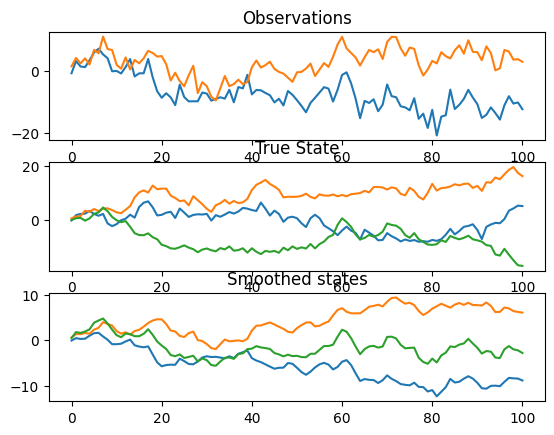

In [ ]:
x_filt, Xi_filt, x_pred, Xi_pred = kalman(y, x0, Sigma, Omega, A, B)

x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)

fig, (ax1, ax2, ax3) = plt.subplots(3, 1)
ax1.set_title("Observations")
ax1.plot(y, label="y")

ax2.plot(x)
ax2.set_title("True State")

ax3.set_title("Smoothed states")
ax3.plot(x_smooth)

plt.show()


In [ ]:
#| hide
#| eval: false
# profiling
from jax.profiler import trace

with trace("/tmp/jax_trace/isssm/kalman"):
    x_filt, Xi_filt, x_pred, Xi_pred = kalman(y, x0, Sigma, Omega, A, B)
    x_filt.block_until_ready()

    
with trace("/tmp/jax_trace/isssm/smoother"):
    x_smooth, Xi_smooth = smoother(x_filt, Xi_filt, x_pred, Xi_pred, A)
    x_smooth.block_until_ready()

## Square Root Filter
The Square Root Filter is based on Cholesky decompositions of the covariance matrices $\Sigma$, $\Xi$ and so on. 

We use Cholesky decompositions of a matrix $A$ of the form $A = LL^T = R^TR$ where $L$ is a lower triangular and $R$ an upper triangular matrix.

We'll use $\grave A$ and $\acute A$ to denote the lower and upper Cholesky decomoposition of $A$, so that 

$$
A = \grave A \grave A^T = \acute A^T \acute A
$$

::: {.callout-note}
## Implementation Detail 
`scipy.linalg.choleksy` by default returns an upper cholesky root $\acute A$ but `np.linalg.cholesy` a lower cholesky root $\grave A$. To get the lower cholesky root from `scipy.linalg.cholesky` use argument `lower = True`.

**Mnemoic:** a**cu**te $\acute A$ is `cu_A` and **gr**ave $\grave A$ is `cr_A`.
:::

The square root filter is then based on "Cholesky Matrix Calculus": 


**Initialization**
$$
\begin{align*}
\hat X_{0|0} &= x_0\\
\acute\Xi_{0|0} &= \acute\Sigma_0
\end{align*}
$$

Iterate for $t = 0, \dots, n-1$


**Prediction**

Updating the covariance is based on the following QR-decompositions
$$
\begin{align*}
    \begin{pmatrix}
        \acute\Sigma_{t + 1} & 0 \\
        \acute\Xi_{t|t} A_t^T & \acute \Xi_{t | t}
    \end{pmatrix}
    = 
    Q_{t + 1 | t} \begin{pmatrix}
        \acute\Xi_{t +1|t} & \acute \Xi_{t + 1 | t}G_t^T \\
        0 & \acute H_{t+1|t}
    \end{pmatrix} 
\end{align*}
$$
where $Q_{t+1|t}$ is a orthogonal matrix and $H_{t + 1 | t}= \Xi_{t | t} - G_{t}\Xi_{t + 1 |  t}G_t^T$ which will be used in the smoothing step later.


The predicted states  are as in the usual Kalman Filter:
$$
\begin{align*}
\hat X_{t + 1 | t} &= A_{t} \hat X_{t | t}
\end{align*}
$$

::: {.callout-note}
# Implementation Detail
I will denote Cholesky decompositions in the following code with a `cu` (for upper triangular) and `cl` (for lower triangular) prefix.

That is `cu_Xi_pred` is $\acute\Xi_{t + 1 | t}$ and `cl_Xi_filt` is $\grave \Xi_{t + 1|t + 1}$ and so on.
:::

In [ ]:
#| export
def sqrt_predict(x_filt, cu_Xi_filt, A, cu_Sigma):
    x_pred = A @ x_filt
    matrix_to_rotate = jnp.block([
        [cu_Sigma, jnp.zeros_like(cu_Sigma)],
        [cu_Xi_filt @ A.T, cu_Xi_filt]
    ])

    Q_pred, R_pred = jnp.linalg.qr(matrix_to_rotate)
    m, = x_filt.shape

    cu_Xi_pred = R_pred[:m,:m]
    G = jsla.solve_triangular(cu_Xi_pred, R_pred[:m,m:], lower=False).T

    cu_H = R_pred[m:, m:]
    
    return x_pred, cu_Xi_pred, G, cu_H

**Filtering**

For the covariances we use
$$
\begin{align*}
    \begin{pmatrix}
        \acute\Omega_{t + 1}& 0 \\
        \acute \Xi_{t + 1 | t} B_{t + 1}^T & \acute \Xi_{t + 1 | t}
    \end{pmatrix}
    =
    Q_{t + 1 | t + 1}\begin{pmatrix}
        \acute\Psi_{t + 1 | t}& \acute\Psi_{t + 1 | t} K_{t + 1}^T \\
        0 & \acute \Xi_{t + 1 | t + 1}
    \end{pmatrix} 
\end{align*}
$$
where $Q_{t + 1 | t + 1}$ is an orthogonal matrix.

For the filtered states note that

$$
    \hat X_{t + 1 | t + 1} = \hat X_{t + 1|t} + K_{t + 1} (Y_{t + 1} - \hat Y_{t + 1 | t})
$$

and $K_{t + 1}$ can be recovered from above matrix by inverting $\acute \Psi_{t + 1 | t}$.



In [ ]:
#| export
def sqrt_filter(x_pred, cu_Xi_pred, cu_Omega, B, y):
    y_pred = B @ x_pred

    p, m = B.shape

    matrix_to_rotate = jnp.block([
        [cu_Omega, jnp.zeros((p,m))],
        [cu_Xi_pred @ B.T, cu_Xi_pred]
    ])

    Q_filt, R_filt = jnp.linalg.qr(matrix_to_rotate)

    cu_Psi_pred = R_filt[:p, :p]
    K = jsla.solve_triangular(cu_Psi_pred, R_filt[:p, p:], lower=False).T
    cu_Xi_filt = R_filt[p:,p:]

    x_filt = x_pred + K @ (y - y_pred)

    return x_filt, cu_Xi_filt


Putting all of this together we obtain the Kalman filter in square root form:

In [ ]:
#|export

def sqrt_kalman(
    y: Float[Array, "n+1 p"],
    x0: Float[Array, "m"],
    cu_Sigma: Float[Array, "n+1 m m"],
    cu_Omega: Float[Array, "n+1 p p"],
    A: Float[Array, "n m m"],
    B: Float[Array, "n+1 p m"],
):
    def step(carry, inputs):
        x_filt, cu_Xi_filt = carry
        y, cu_Sigma, cu_Omega, A, B = inputs

        x_pred, cu_Xi_pred, G, cu_H = sqrt_predict(x_filt, cu_Xi_filt, A, cu_Sigma)
        x_filt_next, cu_Xi_filt_next = sqrt_filter(x_pred, cu_Xi_pred, cu_Omega, B, y)

        return (x_filt_next, cu_Xi_filt_next), (x_filt_next, cu_Xi_filt_next, x_pred, cu_Xi_pred, G, cu_H)

    # artificial state X_{-1} with mean x_0
    # covariance zero, transition identity
    # will lead to X_0 having correct predictive distribution
    # this avoids having to compute a separate filtering step beforehand
    m, = x0.shape
    A_ext = jnp.concatenate(
        (jnp.eye(m)[jnp.newaxis], A)
    )

    _, (x_filt, cu_Xi_filt, x_pred, cu_Xi_pred, G, cu_H) = scan(
        step, (x0, jnp.zeros((m,m))), (y, cu_Sigma, cu_Omega, A_ext, B)
    )

    return x_filt, cu_Xi_filt, x_pred, cu_Xi_pred, G, cu_H

In [ ]:
cu_Sigma = jsla.cholesky(Sigma)
cu_Omega= jsla.cholesky(Omega)
cx_filt, cu_Xi_filt, cx_pred, cu_Xi_pred, G, cu_H = sqrt_kalman(y, x0, cu_Sigma, cu_Omega, A, B)

def Grammian(A):
    return A.T @ A
vGrammian = vmap(Grammian)


npt.assert_allclose(cx_filt, x_filt)
npt.assert_allclose(cx_pred, x_pred)
npt.assert_allclose(vGrammian(cu_Xi_filt), Xi_filt)
npt.assert_allclose(vGrammian(cu_Xi_pred), Xi_pred)

## Square Root Smoother
We obtain Cholesky decompositions of the smoothed covariance matrices by the following QR decomposition:

$$
\begin{align*}
    \begin{pmatrix}
        \acute\Xi_{t + 1 | n} G_t \\
        \acute H_{t + 1 | t}
    \end{pmatrix}
    = 
    Q_{t|n} \begin{pmatrix}
        \acute \Xi_{t | n}\\
        0
    \end{pmatrix} 
\end{align*}
$$

and smoothed states by 

$$
\begin{align*}
    \hat X_{t | n} &= \hat X_{t | t} + G_t (\hat X_{t + 1| n} - \hat X_{t + 1 | t}) 
\end{align*}
$$

as $G_t$ has already been obtained.

In [ ]:
#| export
def sqrt_smooth_step(
    x_filt: State,
    x_pred_next: State,
    x_smooth_next: State,
    cu_Xi_smooth_next: StateCov,
    G: Float[Array, "m m"],
    cu_H: Float[Array, "m m"]
):
    m, = x_filt.shape
    err = x_smooth_next - x_pred_next

    x_smooth = x_filt + G @ err
    matrix_to_rotate = jnp.block([
        [cu_Xi_smooth_next @ G],
        [cu_H]
    ])

    Q_smooth, R_smooth = jnp.linalg.qr(matrix_to_rotate)

    cu_Xi_smooth = R_smooth[:m,:m]

    return (x_smooth, cu_Xi_smooth)

def sqrt_smoother(
    x_filt: Float[Array, "n+1 m"],
    cu_Xi_filt: Float[Array, "n+1 m m"],
    x_pred: Float[Array, "n+1 m"],
    cu_Xi_pred: Float[Array, "n+1 m m"],
    G: Float[Array, "n m m"],
    cu_H: Float[Array, "n m m"]
):
    def step(carry, inputs):
        x_smooth_next, cu_Xi_smooth_next = carry
        x_filt, x_pred_next, G, cu_H = inputs

        x_smooth, cu_Xi_smooth = sqrt_smooth_step(
            x_filt, x_pred_next, x_smooth_next, cu_Xi_smooth_next, G, cu_H
        )

        return (x_smooth, cu_Xi_smooth), (x_smooth, cu_Xi_smooth)

    _, (x_smooth, cu_Xi_smooth) = scan(
        step, (x_filt[-1], cu_Xi_filt[-1]), (x_filt[:-1], x_pred[1:], G[1:], cu_H[1:]), reverse=True
    )

    x_smooth = jnp.concatenate([x_smooth, x_filt[None, -1]])
    cu_Xi_smooth = jnp.concatenate([cu_Xi_smooth, cu_Xi_filt[None, -1]])

    return x_smooth, cu_Xi_smooth

In [ ]:
cx_smooth, cu_Xi_smooth = sqrt_smoother(cx_filt, cu_Xi_filt, cx_pred, cu_Xi_pred, G, cu_H)

npt.assert_allclose(cx_smooth, x_smooth)
npt.assert_allclose(vGrammian(cu_Xi_smooth), Xi_smooth)

In [ ]:
#| hide
#| eval: false
# profiling
from jax.profiler import trace
from jax import jit

with trace("/tmp/jax_trace/issm/sqrt_kalman"):
    cx_filt, cu_Xi_filt, cx_pred, cu_Xi_pred, G, cu_H = sqrt_kalman(y, x0, cu_Sigma, cu_Omega, A, B)
    cx_filt.block_until_ready()

    
with trace("/tmp/jax_trace/issm/sqrt_smoother"):
    cx_smooth, cu_Xi_smooth = sqrt_smoother(cx_filt, cu_Xi_filt, cx_pred, cu_Xi_pred, G, cu_H)
    cx_smooth.block_until_ready()

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()